# FCC Neural Network SMS Text Classification (ML with Python Project) (RNN - NLP)

In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam":
- A "ham" message is a normal message sent by a friend.
- A "spam" message is an advertisement or a message sent by a company.

You should create a function called ```predict_message``` that takes a message string as an argument and returns a list:
- The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1).
- The second element in the list should be the word "ham" or "spam", depending on which is most likely.

For this challenge, you will use the [SMS Spam Collection](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/) dataset. The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.

**Link:** https://www.freecodecamp.org/learn/machine-learning-with-python/machine-learning-with-python-projects/neural-network-sms-text-classifier

## 1. Import Libraries

In [1]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  #!pip install tf-nightly
  !pip install tensorflow
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 22.12.6
    Uninstalling flatbuffers-22.12.6:
      Successfully uninstalled flatbuffers-22.12.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-nightly 2.12.0.dev20221229 requires flatbuffers>=2.0, but you have flatbuffers 1.12 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2.12.0-dev20221229


## 2. Import Data

In [2]:
# get data files
!wget -nc https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget -nc https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

# Read/Load files into dataframes
train = pd.read_table(train_file_path, names=['label', 'message'])
test = pd.read_table(test_file_path, names=['label', 'message'])

File ‘train-data.tsv’ already there; not retrieving.

File ‘valid-data.tsv’ already there; not retrieving.



## 3. Insert Your Code

In [3]:
# NOTICE:

# An online article/tutorial from towardsdatascience.com called "NLP: Spam Detection 
# in SMS (text) data using Deep Learning", written on July 27th of 2020 by
# Sudip Shrestha, PhD was carefully followed by myself (André) and its code was adapted 
# so that I could be able to implement this freeCodeCamp project.

# As the article states:
# "The purpose of this article is to understand how we can use TensorFlow2 to build 
# SMS spam detection model. Particularly, we will build a binary classification model 
# to detect whether a text message is spam or not (aka Ham). Moreover, we’ll learn 
# how to implement Dense, Long Short Term Memory (LSTM) and Bidirectional-LSTM (Bi-LSTM) 
# deep learning models in TensorFlow2 Keras API."

# Source: https://towardsdatascience.com/nlp-spam-detection-in-sms-text-data-using-deep-learning-b8632db85cc8

In [4]:
# import libraries for reading data, exploring and plotting
#import numpy as np
#import pandas as pd
import seaborn as sns
#import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#%matplotlib inline

# library for train test split
from sklearn.model_selection import train_test_split

# deep learning libraries for text pre-processing
#import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# modelling
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

In [5]:
# see python's version
import sys; print(sys.version)

# store each model evaluation for later comparison
models_evaluation = {}

3.8.16 (default, Dec  7 2022, 01:12:13) 
[GCC 7.5.0]


### Uniting Train And Test Datasets

In [6]:
# Going to unite training and testing datasets as to be easier to manipulate and
# analyse the data
df = train.append(test).reset_index(drop=True)

### 1. Exploring The Data

In [7]:
df.tail(3)

,label,message
5568,ham,where are you ? what are you doing ? are yuou ...
5569,spam,ur cash-balance is currently 500 pounds - to m...
5570,spam,not heard from u4 a while. call 4 rude chat pr...


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5571 entries, 0 to 5570
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5571 non-null   object
 1   message  5571 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [9]:
df.describe()

# Analysis:
# - We have a total of 5571 labels and SMS messages.
# - There are 2 unique labels: 'ham' or 'spam'.
# - There are less unique messages (5156) than total messages count (5571), indicating
# some repeated messages.
# - The most frequent label is 'ham', and the most frequent 'message' is 
# "sorry, i'll call later" with 30 duplicated messages.

,label,message
count,5571,5571
unique,2,5156
top,ham,"sorry, i'll call later"
freq,4824,30


In [10]:
duplicated_rows = df[ df.duplicated() ]
print(duplicated_rows.count())

# Analysis:
# - There are 415 duplicated messages (rows with repeated label and message).

label      415
message    415
dtype: int64


In [11]:
df.groupby('label').describe().T

# Analysis:
# - There are 4824 'ham' messages (86%) as opposed to 747 'spam' messages (13%). This
# indicates we have an imbalanced data, which needs to be fixed.
# - The most popular 'ham' message is "sorry, i'll call later" occurring 30 times, whereas
# the most popular 'spam' message is "please call our customer service representativ..."
# occurring 4 times.

label                              ham  \
message count                     4824   
        unique                    4514   
        top     sorry, i'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                642  
        top     please call our customer service representativ...  
        freq                                                    4

In [12]:
# Now, we will use WordCloud to visualize which words are most frequent in each
# class (ham and spam)

# get all the ham and spam messages
ham_msg = df[ df.label == 'ham' ]
spam_msg = df[ df.label == 'spam' ]

# convert ham and spam messages into unique strings to visualize using wordcloud
ham_msg_text = "".join(ham_msg.to_numpy().flatten().tolist())
spam_msg_text = "".join(spam_msg.to_numpy().flatten().tolist())

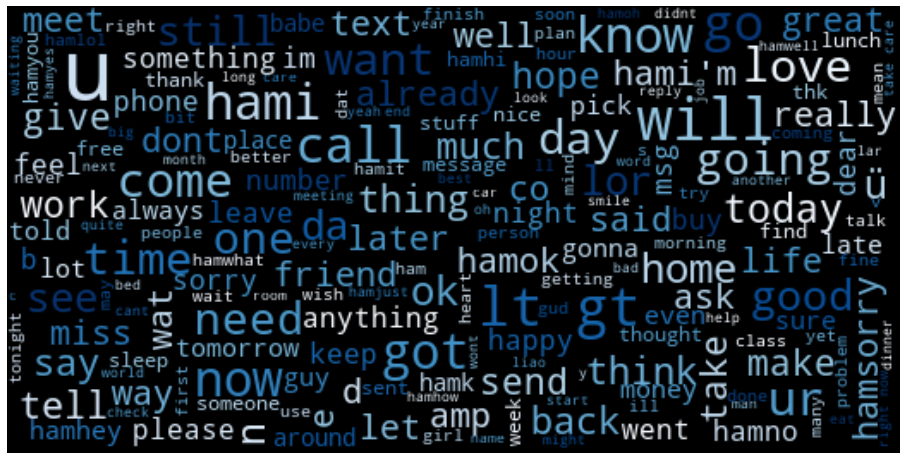

In [13]:
# WordCloud() extracts most commonly found words in ham and spam messages,
# removing "stop words" such as 'the', 'a', 'is', etc., and plot it.

def plot_word_cloud(text):
  msg_cloud = WordCloud(
    width=520, height=260,
    stopwords=STOPWORDS,
    max_font_size=50,
    background_color='black', colormap='Blues'
    ).generate(text)
  plt.figure(figsize=(16,10))
  plt.imshow(X=msg_cloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

# wordcloud of ham messages
plot_word_cloud(ham_msg_text)

# Analysis:
# - The 'ham' message word cloud shows that the most commonly appeared words are:
# 'will', 'got', 'need', 'know'

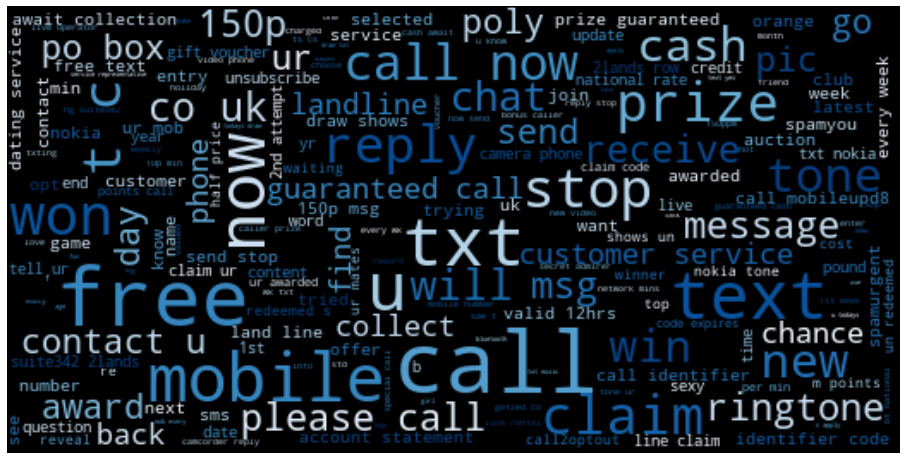

In [14]:
# wordcloud of spam messages
plot_word_cloud(spam_msg_text)

# Analysis:
# - The 'spam' message word cloud shows that the most commonly appeared words are:
# 'free', 'call', 'mobile', 'claim', 'now', 'call', 'prize'

Messages (ham, spam) %: (86.59127625201938, 13.408723747980615)



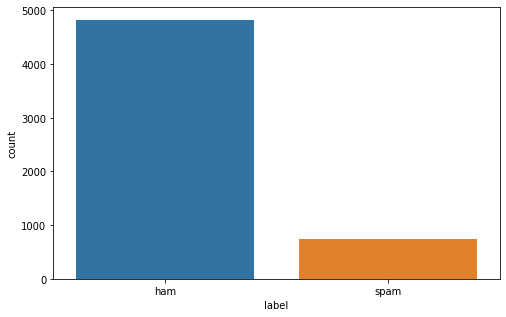

In [15]:
# Explore the imbalanced data

def get_ham_spam_percentages(df):
  ham_count = df['label'].value_counts()['ham']
  spam_count = df['label'].value_counts()['spam']
  total = df['label'].count()
  ham_pct = (ham_count / total) * 100
  spam_pct = (spam_count / total) * 100
  return (ham_pct, spam_pct)

plt.figure(figsize=(8,5))
sns.countplot(x=df.label)
print('Messages (ham, spam) %:', get_ham_spam_percentages(df))
print()

# Analysis:
# - Only 13% of all the messages are labelled as 'spam'.
# - To handle imbalanced data we can undersample/downsample the training set.
# Downsampling is a process where you randomly delete some of the observations from
# the majority class (ham) so that the numbers in majority and minority (spam) classes are
# matched.

In [16]:
# We fix the imbalanced data by downsampling ham messages (majority class) to
# the same number of spam messages (minority class), i.e., to 747 messages in
# each class
n_samples = len(spam_msg)
ham_msg_df = ham_msg.copy().sample(n=n_samples, random_state=44)
spam_msg_df = spam_msg.copy()
print(ham_msg_df.shape, spam_msg_df.shape)

# Note: random_state argument is for reproducibility (if integer provided);
# "None" to not have reproducibility

(747, 2) (747, 2)


Text(0.5, 0, 'Message types')

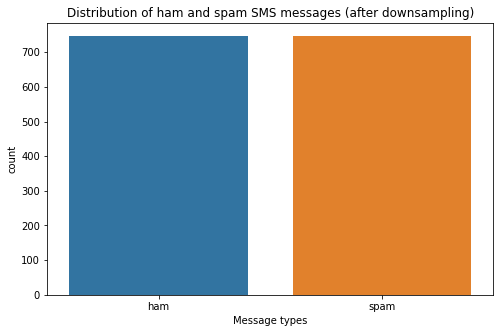

In [17]:
# create a single dataframe with the ham and spam dataframes
msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)

# plot distribution of ham and spam SMS messages (after downsampling)
plt.figure(figsize=(8,5))
sns.countplot(x=msg_df.label)
plt.title('Distribution of ham and spam SMS messages (after downsampling)')
plt.xlabel('Message types')

In [18]:
# get length column for each text entry
msg_df['text_length'] = msg_df['message'].apply(len)

# calculate average length by label types
labels = msg_df.groupby('label').mean()
labels

# Analysis:
# - On average:
# -- the 'ham' message has a length of 70 words;
# -- the 'spam' message has a length of 138 words.
# Note: This length info shall be useful later when setting "maxlen" parameter.

,text_length
label,
ham,70.653280
spam,138.601071


### 2. Data Preprocessing

In [19]:
# Convert text label to numeric
# Map 'ham' label as 0 and 'spam' as 1
msg_df['msg_type'] = msg_df['label'].map({ 'ham': 0, 'spam': 1 })

# Convert label to numpy arrays to fit deep learning models
msg_label = msg_df['msg_type'].values # numpy array

# Split data into training set (80%) and testing set (20%)
train_features, test_features, train_labels, test_labels = train_test_split(
    msg_df['message'], msg_label, test_size=0.2, random_state=434)

In [20]:
# Use text pre-processing: Tokenization, Sequencing and Padding

# Process flow in text pre-processing:
# 1. Text:            ["Hello world!", "I am here."]
# 2. Tokens:          ['hello', 'world', 'I', 'am', 'here', '.']
# 3. Word Index:      ['hello': 1, 'world': 2, 'i': 3, 'am': 4, 'here': 5]
# 4. Sequence:        [ [1, 2],
##                      [3, 4, 5] ]
# 5. Padded Sequence: [ [0, 1, 2]
##                      [3, 4, 5] ]

In [21]:
# Tokenization (convert text into numerical representation)

# Tokenizer() splits sentences into words and encodes these into integers.
# Tokenizer() does all the required pre-processing:
## - tokenize into word or character - here we use at word level (not character level);
## - num_words for maximum number of unique tokens hence we can filter out rare words;
## - filter out punctuation terms;
## - convert all words to lower case;
## - convert all words to integer index.

# First, define hyper-parameters for pre-processing
max_len = 50 # maximum number of words per sentence (SMS message)
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>" # when used, out-of-vocabulary token will be added to word index
# in the corpus which is used to build the model. This is used to replace
# out-of-vocabulary words (words that are not in our corpus) during
# text_to_sequence calls
vocab_size = 500 # how many unique words to load in training and testing data

# Second, use Tokenizer() to tokenize the words
tokenizer = Tokenizer(num_words=vocab_size, char_level=False, oov_token=oov_tok)
tokenizer.fit_on_texts(train_features)
## If char_level=True, then every character will be treated as a token.
## If char_level=False, then every word will be treated as a token.

# Get total words from word_index
word_index = tokenizer.word_index
total_words = len(word_index)

In [22]:
#print(word_index)
#{'<OOV>': 1, 'to': 2, 'you': 3, 'a': 4, 'i': 5, ...}

# Check how many words are indexed
print('There are {words} unique tokens in training data.'.format(words=total_words))

There are 4136 unique tokens in training data.


In [23]:
# Sequencing (represent each sentence by sequences of numbers)
# and Padding (pad each sequence for all sequences of numbers to have the same length)
# on training and testing

training_sequences = tokenizer.texts_to_sequences(train_features)
training_padded = pad_sequences(
    training_sequences, maxlen=max_len,
    padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(test_features)
testing_padded = pad_sequences(
    testing_sequences, maxlen=max_len,
    padding=padding_type, truncating=trunc_type)

## padding = 'pre' (pad before each sequence) or 'post' (pad after each sequence).
# (default 'pre').
## maxlen = maximum length of all sequences. max_len=50 means only using 50 words
# in a sentence. If not provided, defaults to the maximum length of the longest sentence.
## truncating = 'pre' or 'post'. If sequence length > provided maxlen, then these
# values will be truncated to maxlen. 'pre' option will truncate at the beginning whereas
# "post" will truncate at the end of the sequences. (default 'pre').

In [24]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

# Analysis:
# - There are 1195 training sequences (sentences), each with 50 tokens (words)
# - There are 299 testing sequences (sentences), each with 50 tokens (words)

Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


In [25]:
print('Before padding:')
print( (len(training_sequences[0]), len(training_sequences[1])) )
print()
print('After padding:')
print( (len(training_padded[0]), len(training_padded[1])) )

# Analysis:
# - Before padding, first sequence was 31 words long, whereas second one was 27 words long.
# - After padding, both sequences have length of 50 words.

Before padding:
(31, 27)

After padding:
(50, 50)


In [26]:
# Padded sequence of the first sentence
print(training_padded[0])
print(len(training_padded[0]))

# Analysis:
# - As mentioned, there are 50 tokens in the first sequence.

[ 64  31  87   3 392  13  38   8  15 131  74   1   4   1  62   1   1  10
   8   1   7  19   1   1   1 149   1   1  64 220 139   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
50


### 3. Modelling

In [27]:
# Word Embedding

# - In an embedding, words are represented by dense vectors where a vector represents
# the projection of the word into a continuous vector space.
# - The position of a word within the vector space is learned from text and is based
# on the words that surround the word when it is used.
# - The position of a word in the learned vector space is referred to as its embedding.

# - It requires that the input data be integer encoded, so that each word is
# represented by a unique integer.
# - The Embedding layer is initialized with random weights and will learn an embedding
# for all of the words in the training dataset.

# - The Embedding layer is defined as the first hidden layer of a network.
# It must specify 3 arguments:
## -- input_dim: This is the size of the vocabulary in the text data. For example,
# if your data is integer encoded to values between 0-10, then the size of the
# vocabulary would be 11 words.
## -- output_dim: This is the size of the vector space in which words will be embedded.
# It defines the size of the output vectors from this layer for each word. For example,
# it could be 32 or 100 or even larger. Test different values for your problem.
## -- input_length: This is the length of input sequences, as you would define for any
# input layer of a Keras model. For example, if all of your input documents are comprised
# of 1000 words, this would be 1000.

# Source: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

#### Dense Spam Detection Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
______________________________________________________

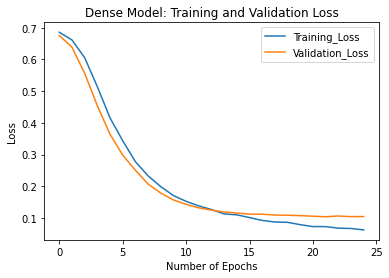

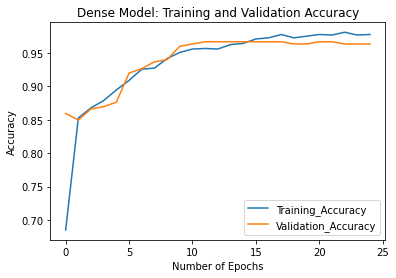

In [28]:
# Dense Spam Detection Model

# Define model hyper-parameters
vocab_size = 500 # as defined earlier
embedding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24

# Define a Dense model architecture
model1 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    GlobalAveragePooling1D(),
    #tf.keras.layers.Flatten(), # use this layer instead of GlobalAveragePooling1D
    Dense(24, activation='relu'),
    Dropout(drop_value),
    Dense(1, activation='sigmoid')
])

# Analysis:
# - The first layer (input hidden layer: embedding layer) maps each word to a N-dimensional vector of
# real numbers. The embedding_dim is the size of this vector which is 16 in our case.
# The embedding layer indicates that the two words with a similar meaning tend to have
# very close vectors. Because the embedding layer is the first hidden layer in our
# model network, we need to pass shape of our input layer as defined by input_length
# (max_len=50).
# - The second layer (hidden layer: pooling layer) helps to reduce the number of parameters in the
# model, hence helps to avoid overfitting. It is being used average pooling and
# converted layer to 1 dimension. Pooling can be understood as downsampling.
# - The third layer (hidden layer: dense layer) uses 24 neurons with 'relu' activation function (Rectified
# Linear Unit - squashes values between 0 and POSITIVE INFINITY).
# - The fourth layer (hidden layer: dropout layer) helps avoid overfitting.
# - The final layer (output layer) uses a single output neuron with 'sigmoid' activation
# function (Sigmoid - squashes values between 0 and 1, i.e. outputs probabilities between 0
# and 1). Since there are only two classes to classify ('ham' or 'spam'), only a single 
# output neuron is used.

# This is a fairly shallow neural network architecture. It is possible to make it more
# dense by adding more layers.


model1.summary()

# Analysis:
# - Model summary provides the layer, shape and number of parameters used in each layer.
# - In the embedding layer, the 8000 parameter comes from 500 words (vocab_size), each
# one with a 16 dimensional word-vector space (500 * 16 = 8000).
# - The embedding layer is passed through GlobalAveragePooling1D and into dense layers
# have shape of 16 (due to the average pooling along 16 embedding dimension).
# It was selected 24 neurons for the dense hidden layer. Each of the 24 neurons in the
# dense layer gets input from each of the 16 values coming from the GlobalAveragePooling1D
# layer, for a total of 384 (16 * 24) weights and 24 biases (one for each 24 neurons).
# Hence the total parameter is 408. Finally, the output layer has 24 weights (one for
# each neuron) and its one bias term resulting 25 parameters in total.

# The Embedding layer has a vocabulary of 500 and an input length of 50.
# The output from the Embedding layer will be 500 vectors of 16 dimensions each
# (one vector for each word).


# Compiling the Dense model
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Analysis:
# - 'binary_crossentropy' loss function is used because of binary output ('ham' or 'spam').
# - 'adam' optimizer function is used which makes use of momentum to avoid local minima.
# - 'accuracy' metrics is used as a measure of model performance.


# Training (fitting) and evaluating the Dense model

# Fitting hyper-parameters:
num_epochs = 30 
early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model1.fit(
    x=training_padded, y=train_labels,
    epochs=num_epochs,
    validation_data=(testing_padded, test_labels),
    callbacks=[early_stop],
    verbose=2)

# Analysis:
# - num_epochs - number of times the learning algorithm will work through the
# entire training data set.
# - early_stop - monitor validation loss metric and if validation loss it not
# improved after two epochs, then the model training is stopped. It helps to 
# avoid overfitting problem and indicates when to stop training before learner
# begins to over-fit.
# - verbose=2 - prints loss and accuracy metrics on each epoch

# - The model resulted in:
# (loss: 0.0580 - accuracy: 0.9824 - val_loss: 0.1095 - val_accuracy: 0.9699)
## -- training loss (0.05), training accuracy (98%)
## -- validation loss (0.10), validation accuracy (97%)

# Model performance on test data
models_evaluation['rnn_dense'] = model1.evaluate(x=testing_padded, y=test_labels)
[val_loss, val_accuracy] = models_evaluation['rnn_dense']
print("\nValidation output: loss: {} - accuracy: {}".format(val_loss, val_accuracy))


# Visualize history results by plotting loss and accuracy by number of epochs
metrics = pd.DataFrame(history.history)

def rename_metrics_columns(metrics):
  metrics.rename(columns={
    'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
    'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'},
    inplace=True)
rename_metrics_columns(metrics)

def plot_graphs(var1, var2, string, metrics, model_title):
  metrics[[var1, var2]].plot()
  plt.title(f'{model_title}: Training and Validation ' + string)
  plt.xlabel('Number of Epochs')
  plt.ylabel(string)
  plt.legend([var1, var2])
  plt.show()
plot_graphs('Training_Loss', 'Validation_Loss', 'Loss', metrics, 'Dense Model')
plot_graphs('Training_Accuracy', 'Validation_Accuracy', 'Accuracy', metrics, 'Dense Model')

#### LSTM Spam Detection Model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            8000      
                                                                 
 lstm (LSTM)                 (None, 50, 20)            2960      
                                                                 
 lstm_1 (LSTM)               (None, 50, 20)            3280      
                                                                 
 dense_2 (Dense)             (None, 50, 1)             21        
                                                                 
Total params: 14,261
Trainable params: 14,261
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
38/38 - 16s - loss: 0.6649 - accuracy: 0.6405 - val_loss: 0.5541 - val_accuracy: 0.7029 - 16s/epoch - 418ms/step
Epoch 2/30
38/38 - 2s - loss: 0.4008 - accuracy: 0.8433 - 

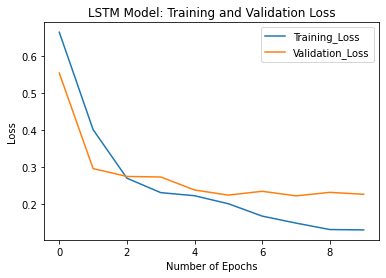

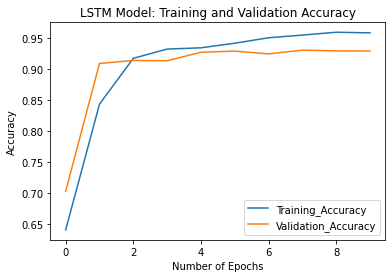

In [29]:
# LSTM Spam Detection Model (Long Short Term Memory)

# Define model hyper-parameters
n_lstm = 20 # number of nodes in the hidden layers within the LSTM cell
drop_lstm = 0.2 # drops learnable parameters between layers, which helps avoid overfitting

# Define a LSTM model architecture
model2 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    LSTM(n_lstm, dropout=drop_lstm, return_sequences=True),
    LSTM(n_lstm, dropout=drop_lstm, return_sequences=True),
    Dense(1, activation='sigmoid')
])

# Analysis:
# - n_lstm=20 is the number of nodes in the hidden layers within the LSTM cell.
# - return_sequences=True ensures that the LSTM cell returns all of the outputs from
# the unrolled LSTM cell through time. If this argument is not used, the LSTM cell
# will simply provide the output of the LSTM cell from the previous step.

# What is unrolling in LSTM?
# "Unroll" is a way to transform the recurrent calculations into a single graph without
# recurrence. This is a trade-off: faster processing, but consumes more memory. It's
# best for short sequences, which have low memory overhead.

# Why do we do loop unrolling?
# Loop unrolling is a loop transformation technique that helps to optimize the execution
# time of a program. We basically remove or reduce iterations. Loop unrolling increases
# the program's speed by eliminating loop control instruction and loop test instructions.


model2.summary()

# Analysis:
# - 


# Compiling the LSTM model
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Analysis:
# (same as Dense model)


# Training (fitting) and evaluating the LSTM model

# Fitting hyper-parameters
# (same as Dense model, except applying reshape() function on labels)
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)

history = model2.fit(
    x=training_padded, y=train_labels.reshape(-1,1),
    epochs=num_epochs, validation_data=(testing_padded, test_labels.reshape(-1,1)),
    callbacks=[early_stop],
    verbose=2)

# Analysis:
# - 

# - The model resulted in:
# loss: 0.1181 - accuracy: 0.9605 - val_loss: 0.1969 - val_accuracy: 0.9371
## -- training loss (0.11), training accuracy (96%)
## -- validation loss (0.19), validation accuracy (94%)

# Model performance on test data
models_evaluation['rnn_lstm'] = model2.evaluate(x=testing_padded, y=test_labels.reshape(-1,1))
[val_loss, val_accuracy] = models_evaluation['rnn_lstm']
print("\nValidation output: loss: {} - accuracy: {}".format(val_loss, val_accuracy))


# Visualize history results by plotting loss and accuracy by number of epochs
metrics = pd.DataFrame(history.history)
rename_metrics_columns(metrics)
plot_graphs('Training_Loss', 'Validation_Loss', 'Loss', metrics, 'LSTM Model')
plot_graphs('Training_Accuracy', 'Validation_Accuracy', 'Accuracy', metrics, 'LSTM Model')

#### Bi-LSTM Spam Detection Model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            8000      
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 50, 1)             41        
                                                                 
Total params: 13,961
Trainable params: 13,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
38/38 - 7s - loss: 0.6700 - accuracy: 0.6026 - val_loss: 0.5813 - val_accuracy: 0.7619 - 7s/epoch - 197ms/step
Epoch 2/30
38/38 - 1s - loss: 0.4256 - accuracy: 0.8686 - val_loss: 0.2897 - val_accuracy: 0.9310 - 1s/epoch - 36ms/step
Epoch

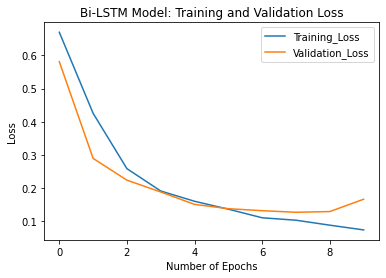

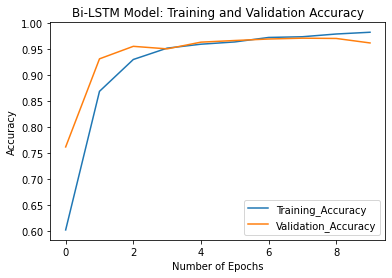

In [30]:
# Bi-LSTM Spam Detection Model (Bidirectional Long Short Term Memory)

# Note: Unlike in LSTM, the Bi-LSTM learns patterns from both before
# and after a given token within a document. The Bi-LSTM back-propagates in
# both backward and forward directions in time. Due to this, the computational
# time is increased compared to LSTM. However, in most of the cases Bi-LSTM
# results in better accuracy.

# Define model hyper-parameters
# (same as LSTM model)

# Define a Bi-LSTM model architecture
model3 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)),
    Dense(1, activation='sigmoid')
])

# Analysis:
# - Only difference than LSTM is that we use Bidirectional wrapper to LSTM.


model3.summary()

# Analysis:
# - 


# Compiling the Bi-LSTM model
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Analysis:
# (same as Dense model)


# Training (fitting) and evaluating the Bi-LSTM model

# Fitting hyper-parameters
# (same as Dense model, except applying reshape() function on labels)
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)

history = model3.fit(
    x=training_padded, y=train_labels.reshape(-1,1),
    epochs=num_epochs, validation_data=(testing_padded, test_labels.reshape(-1,1)),
    callbacks=[early_stop],
    verbose=2)

# Analysis:
# - 

# - The model resulted in:
# loss: 0.0700 - accuracy: 0.9827 - val_loss: 0.1192 - val_accuracy: 0.9722
## -- training loss (0.07), training accuracy (98%)
## -- validation loss (0.11), validation accuracy (97%)

# Model performance on test data
models_evaluation['rnn_bilstm'] = model3.evaluate(x=testing_padded, y=test_labels.reshape(-1,1))
[val_loss, val_accuracy] = models_evaluation['rnn_bilstm']
print("\nValidation output: loss: {} - accuracy: {}".format(val_loss, val_accuracy))


# Visualize history results by plotting loss and accuracy by number of epochs
metrics = pd.DataFrame(history.history)
rename_metrics_columns(metrics)
plot_graphs('Training_Loss', 'Validation_Loss', 'Loss', metrics, 'Bi-LSTM Model')
plot_graphs('Training_Accuracy', 'Validation_Accuracy', 'Accuracy', metrics, 'Bi-LSTM Model')

### 4. Compare Models And Choose Best

In [31]:
# Comparing three different models

# Create dataframe from the models evaluation dict
evals = pd.DataFrame(models_evaluation, index=['Validation_Loss', 'Validation_Accuracy'])
evals.columns = ['Dense', 'LSTM', 'Bi-LSTM']

# Transpose and sort values by loss (ascending) and accuracy (descending)
evals_sorted = evals.T.sort_values(axis='index', by=['Validation_Loss', 'Validation_Accuracy'], ascending=[True, False])

evals_sorted

# Analysis:
# - All models (Dense, LSTM, and Bi-LSTM) are comparable in terms of loss and accuracy.
# - The validation loss for the three models are 0.10, 0.21, and 0.13.
# - The validation accuracy for the three models are 97%, 93%, and 97%.

# - Among all, both Dense and Bi-LSTM outperformed the LSTM.
# - Based on loss, accuracy and the plots previously seen, we select Dense architecture
# as a final model for classifying the SMS messages for 'spam' or 'ham'. The dense
# classifier has simple structure and the loss and accuracy over epochs are more stable~
# than in Bi-LSTM.

,Validation_Loss,Validation_Accuracy
Dense,0.104758,0.963211
Bi-LSTM,0.166647,0.961472
LSTM,0.225474,0.929030


In [32]:
# Choose best model (with best performance in loss and accuracy)
best_model_name = evals_sorted.head(1).index[0]
model = ''

if best_model_name == 'Dense': model = model1
elif best_model_name == 'LSTM': model = model2
elif best_model_name == 'Bi-LSTM': model = model3

print(f'Best Model Architecture: {best_model_name}')

Best Model Architecture: Dense


### 5. Predict ```spam``` Or ```ham``` (3 Scenarios)

#### Scenario 1: Using Raw Text From Our Data

In [33]:
# Evaluate how Dense spam detection model predicts/classifies wheter it is spam or ham
# given the text from our original data.

# First, use the (same) tokenizer to convert the chosen messages into the sequences.
# This makes sure the new words will have the same token as in the training set.
# Second, use padding and provide the same dimension as in training set.

#pd.options.display.max_colwidth=100
df[6:9]

,label,message
6,ham,genius what's up. how your brother. pls send h...
7,ham,they finally came to fix the ceiling.
8,spam,urgent! call 09066350750 from your landline. y...


In [34]:
# Define prediction function

def predict_spam(predict_msg):
  new_seq = tokenizer.texts_to_sequences(predict_msg)
  padded = pad_sequences(
      new_seq, maxlen=max_len,
      padding=padding_type, truncating=trunc_type)
  return (model.predict(padded))

predict_msg = df[6:9]['message'].values.tolist()
predict_spam(predict_msg)

# Analysis:
# - The model correctly predicts:
## -- the first two sentences as not spam with a probability of 6% and 7%;
## -- the third sentence as spam with a probability of 99%.

1/1 [==============================] - 0s 102ms/step


array([[0.05891198],
       [0.06675353],
       [0.99971724]], dtype=float32)

#### Scenario 2: Using Text Messages From Testing Set

In [35]:
test[697:700]

,label,message
697,ham,was gr8 to see that message. so when r u leavi...
698,ham,"sorry, i'll call later"
699,spam,i don't know u and u don't know me. send chat ...


In [36]:
predict_msg = test[697:700]['message'].values.tolist()
predict_spam(predict_msg)

# Analysis:
# - The model correctly predicts:
## -- the first two sentences as not spam with a probability of 4% and 2%.
## -- the third sentence as spam with a probability of 99%.

1/1 [==============================] - 0s 24ms/step


array([[0.04305653],
       [0.01752015],
       [0.99431515]], dtype=float32)

#### Scenario 3: Using Newly Created Text Message

In [37]:
# Improvise new text message

predict_msg = [" You have been awarded with an amazing prize. Click now",
               "Whatever, I'm off to bed. Can you call me in the morning?",
               "Who do you think you are?"]
predict_spam(predict_msg)

# Analysis:
# - The model correctly predicts:
## -- the first sentence as spam with a probability of 95%.
## -- the last two sentences as not spam with a probability of 1% and 6%.

1/1 [==============================] - 0s 24ms/step


array([[0.94456947],
       [0.01016792],
       [0.05401261]], dtype=float32)

### Implement ```predict_message()``` function

In [38]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])

def get_ham_or_spam(prediction):
  if prediction < 0.5: return 'ham'
  else: return 'spam'

def predict_message(pred_text):
  single_text = type(pred_text) == str
  text = pred_text[:]

  if single_text:
    text = [pred_text] # if one single text, then needs to be inside a list

  new_seq = tokenizer.texts_to_sequences(text)
  padded = pad_sequences(
      new_seq, maxlen=max_len,
      padding=padding_type, truncating=trunc_type)
  
  if single_text:
    prediction = model.predict(padded).flatten()[0]
    output = [ prediction, get_ham_or_spam(prediction) ]
    return output

  else:
    predictions = model.predict(padded)
    output = [ [p, get_ham_or_spam(p)] for p in predictions.flatten() ]
    return output


test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

# predict one message
print(predict_message(test_messages[4]))

# predict a list of messages
predict_message(test_messages)

1/1 [==============================] - 0s 23ms/step
[0.9904993, 'spam']
1/1 [==============================] - 0s 24ms/step


[[0.010882739, 'ham'],
 [0.6063761, 'spam'],
 [0.008486303, 'ham'],
 [0.9927897, 'spam'],
 [0.9904993, 'spam'],
 [0.006394278, 'ham'],
 [0.03157996, 'ham']]

## 9. Test Your Code (FCC)

In [39]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 [==============================] - 0s 25ms/step
You passed the challenge. Great job!
